In [8]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [2]:
np.random.seed(1)
BASIC_ARGS = """
--exp_name test
--height 6
--n_objects 7
--n_colours 4
--seed 1
"""
args = parse_args_str(PARSER, BASIC_ARGS)
print(args.exp_name)

init_start_pos = np.random.randint(0, args.height, size=(args.n_query, 2)).tolist()
print('start positions: ', init_start_pos)

ow, P_a, rewards_gt, values_gt, policy_gt, feat_map = init_object_world(args)
ow.grid

test
start positions:  [[5, 3]]
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration


array([[-1., -1., -1., -1.,  1.,  0.],
       [-1., -1., -1.,  1.,  0.,  0.],
       [-1., -1.,  1.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  1.,  0.,  0.],
       [-1., -1., -1.,  1.,  1.,  0.],
       [-1., -1., -1., -1.,  1.,  1.]])

## Maxent

In [ ]:
MAXENT_ARGS = """
--exp_name maxent_rand
--type object
--n_objects 7
--n_colours 4
--height 6
--width 6
--gamma 0.8
--act_random 0.3
--n_trajs 5
--l_traj 6
--learning_rate 0.1
--n_iters 10
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--active
"""
args = parse_args_str(PARSER, MAXENT_ARGS)
print(args.exp_name)

history_maxent_active = run_maxent_irl(args, init_start_pos=init_start_pos)

In [ ]:
visualizer = Visualizer(history_maxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

---

## Deep Maxent

In [ ]:
init_start_pos

In [10]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 15
--n_colours 2
--height 10
--width 10
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.001
--n_iters 30
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.1
--hiddens 3 3
--device cuda
--active
--seed 1
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=init_start_pos)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[INFO - n_trajs:1] Training Deep MaxEnt IRL


  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:1--
[[0.2566 0.2928 0.3884 0.4565 0.3976 0.3869 0.4127 0.4193 0.4212 0.4301]
 [0.3631 0.3344 0.4297 0.4703 0.4349 0.3887 0.4063 0.4195 0.415  0.4339]
 [0.4594 0.4377 0.4576 0.4587 0.4427 0.4268 0.4105 0.4216 0.4212 0.4301]
 [0.4445 0.421  0.408  0.4244 0.3924 0.3825 0.409  0.4319 0.4383 0.4521]
 [0.4306 0.412  0.3961 0.3846 0.3707 0.3826 0.4137 0.4268 0.3907 0.3594]
 [0.412  0.4004 0.3999 0.4034 0.3773 0.3965 0.4299 0.4354 0.3365 0.2461]
 [0.4233 0.4147 0.4412 0.4587 0.4244 0.3988 0.4232 0.4508 0.3859 0.255 ]
 [0.4342 0.4195 0.4298 0.4636 0.4341 0.4057 0.4337 0.4602 0.4475 0.3576]
 [0.4514 0.4385 0.4212 0.456  0.4412 0.4216 0.4514 0.4651 0.4565 0.3497]
 [0.4507 0.4167 0.4166 0.4288 0.4491 0.4255 0.4175 0.3978 0.4331 0.4075]]
[INFO - n_trajs:1] Policy evaluation
-- evd = 5.110389 ---
[INFO - n_trajs:1] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:1--
[[7.5892 8.2215 8.4491 8.5842 8.7209 8.7619 8.7083 8.5727 8.2071

  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:2--
[[0.3683 0.5111 0.6363 0.7717 0.7912 0.6176 0.3997 0.4894 0.406  0.405 ]
 [0.4532 0.5558 0.6418 0.7428 0.7268 0.7017 0.5541 0.4692 0.2573 0.2448]
 [0.548  0.6267 0.7286 0.732  0.6588 0.7112 0.7271 0.5445 0.406  0.405 ]
 [0.5136 0.6101 0.7967 0.7695 0.708  0.6303 0.6179 0.6145 0.4717 0.383 ]
 [0.4055 0.5871 0.7985 0.8362 0.6593 0.4526 0.5524 0.615  0.6066 0.5631]
 [0.5871 0.6694 0.8343 0.8341 0.7257 0.6044 0.6003 0.6301 0.548  0.543 ]
 [0.7019 0.7065 0.6954 0.732  0.7695 0.6606 0.5342 0.4882 0.4122 0.3276]
 [0.5286 0.4692 0.5338 0.5609 0.6813 0.5465 0.3404 0.4289 0.4454 0.4557]
 [0.372  0.2348 0.406  0.5591 0.6954 0.5445 0.372  0.3286 0.3738 0.2984]
 [0.3388 0.1683 0.366  0.5876 0.7649 0.5897 0.3849 0.2369 0.4147 0.4636]]
[INFO - n_trajs:2] Policy evaluation
-- evd = 7.367843 ---
[INFO - n_trajs:2] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:2--
[[7.0842 7.3299 7.6892 7.9588 7.8738 7.5132 7.1133 7.0609 6.858 

  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:3--
[[0.2692 0.4408 0.4856 0.4714 0.5028 0.5304 0.5397 0.5032 0.436  0.3797]
 [0.4685 0.4688 0.4763 0.4365 0.4876 0.5043 0.5218 0.4878 0.3622 0.1875]
 [0.5292 0.5024 0.4666 0.4531 0.4693 0.4936 0.4962 0.498  0.436  0.3797]
 [0.5567 0.5377 0.5001 0.4953 0.5034 0.5135 0.5152 0.4591 0.3604 0.1887]
 [0.5663 0.5526 0.5203 0.5048 0.5211 0.5408 0.5364 0.4842 0.3978 0.3548]
 [0.5526 0.5345 0.5019 0.5007 0.5181 0.5408 0.546  0.497  0.4446 0.3879]
 [0.5269 0.5009 0.4797 0.4531 0.4953 0.5216 0.5407 0.5267 0.4547 0.2332]
 [0.5187 0.4878 0.4604 0.4089 0.4861 0.513  0.5161 0.5359 0.5133 0.4651]
 [0.4944 0.4114 0.436  0.4429 0.4797 0.498  0.4944 0.493  0.5052 0.3139]
 [0.4795 0.2771 0.4345 0.4676 0.4778 0.4941 0.4719 0.3194 0.5017 0.4989]]
[INFO - n_trajs:3] Policy evaluation
-- evd = 6.053203 ---
[INFO - n_trajs:3] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:3--
[[7.625  8.2279 8.5213 8.6298 8.6111 8.5423 8.3771 8.0638 7.5924

  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:4--
[[-0.1443 -0.1005 -0.0431  0.0251  0.0164 -0.0122 -0.1114 -0.0618 -0.0311
  -0.0026]
 [-0.1823 -0.0771 -0.0129  0.0741  0.0574  0.02   -0.0375 -0.0535 -0.0179
   0.0347]
 [-0.1712 -0.0538  0.0267  0.0817  0.1067  0.0494  0.0062 -0.0448 -0.0311
  -0.0026]
 [-0.1897 -0.0694  0.0108  0.0418  0.0368  0.0125 -0.0238 -0.0072  0.0136
   0.0549]
 [-0.1924 -0.0778 -0.      0.0197  0.0087 -0.0363 -0.067  -0.0217  0.0091
   0.0128]
 [-0.0778 -0.0257  0.0165  0.0255  0.0095 -0.0363 -0.1007 -0.0435 -0.0383
  -0.0241]
 [-0.0422 -0.005   0.0344  0.0817  0.0418 -0.0108 -0.0986 -0.1757 -0.1446
  -0.0874]
 [-0.1011 -0.0535  0.0158  0.1127  0.0471 -0.0296 -0.1482 -0.2303 -0.2255
  -0.1716]
 [-0.181  -0.0861 -0.0311  0.0365  0.0344 -0.0448 -0.181  -0.2527 -0.2964
  -0.1877]
 [-0.2155 -0.1014 -0.1017 -0.0157  0.0192 -0.0577 -0.1942 -0.1754 -0.2924
  -0.2969]]
[INFO - n_trajs:4] Policy evaluation
-- evd = 6.054995 ---
[INFO - n_trajs:4] Calculating the acqu

  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:5--
[[0.4698 0.5067 0.5874 0.6709 0.8925 1.1642 1.3331 0.901  0.6978 0.534 ]
 [0.6291 0.5432 0.624  0.7139 0.932  0.9606 1.0076 0.8418 0.8209 0.4645]
 [0.8349 0.7044 0.67   0.8163 1.0188 0.95   0.7777 0.8063 0.6978 0.534 ]
 [1.2241 1.0389 0.811  0.9317 1.1149 1.0546 0.9121 0.5762 0.4752 0.42  ]
 [1.6058 1.3207 1.0476 1.0551 1.2732 1.3986 1.0978 0.6757 0.4579 0.436 ]
 [1.3207 1.1177 0.8819 0.9393 1.1898 1.2319 1.0897 0.6861 0.5173 0.4475]
 [0.903  0.7805 0.7842 0.8163 0.9317 0.9961 1.1135 0.9269 0.6414 0.4646]
 [0.891  0.8418 0.736  0.7955 0.8794 0.9571 1.2242 1.0704 0.8128 0.6154]
 [0.8912 0.962  0.6978 0.6923 0.7842 0.8063 0.8912 0.8794 0.8642 0.6375]
 [0.8192 0.7315 0.6662 0.6193 0.6838 0.6711 0.7274 0.7264 0.8033 0.7509]]
[INFO - n_trajs:5] Policy evaluation
-- evd = 7.706318 ---
[INFO - n_trajs:5] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:5--
[[3.2664 4.8928 5.8573 5.7926 6.0251 6.1527 5.5574 4.7726 4.2614

  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:6--
[[-0.5875 -0.5569 -0.5248 -0.4964 -0.4767 -0.4839 -0.521  -0.5172 -0.5173
  -0.5116]
 [-0.5608 -0.5422 -0.5093 -0.4758 -0.4479 -0.4604 -0.5035 -0.5171 -0.54
  -0.522 ]
 [-0.5395 -0.5227 -0.4939 -0.4585 -0.4078 -0.447  -0.4903 -0.5138 -0.5173
  -0.5116]
 [-0.5338 -0.5163 -0.4886 -0.4578 -0.427  -0.4622 -0.501  -0.5081 -0.505
  -0.4979]
 [-0.5281 -0.5122 -0.4901 -0.4679 -0.4606 -0.4904 -0.5126 -0.5103 -0.5043
  -0.5027]
 [-0.5122 -0.498  -0.4808 -0.4697 -0.4684 -0.4976 -0.5231 -0.52   -0.5275
  -0.5343]
 [-0.5142 -0.4985 -0.4756 -0.4585 -0.4578 -0.4908 -0.5207 -0.5379 -0.5511
  -0.5801]
 [-0.5267 -0.5171 -0.4849 -0.442  -0.4565 -0.5014 -0.5403 -0.5446 -0.551
  -0.5598]
 [-0.544  -0.556  -0.5173 -0.4821 -0.4756 -0.5138 -0.544  -0.5583 -0.5662
  -0.5882]
 [-0.5543 -0.5791 -0.5396 -0.5093 -0.4966 -0.5244 -0.5551 -0.5854 -0.5691
  -0.5741]]
[INFO - n_trajs:6] Policy evaluation
-- evd = 3.967487 ---
[INFO - n_trajs:6] Calculating the acqusiti

  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:7--
[[ 0.2018  0.2106  0.2146  0.2201  0.1736  0.0818 -0.0649  0.0655  0.0362
   0.0808]
 [ 0.209   0.2093  0.1949  0.174   0.1033  0.1099  0.0727  0.058  -0.1845
  -0.0397]
 [ 0.2018  0.2083  0.2019  0.1244 -0.0493  0.0933  0.1734  0.12    0.0362
   0.0808]
 [ 0.0973  0.1402  0.1943  0.1428  0.0739  0.0611  0.1242  0.19    0.1457
   0.1326]
 [-0.0231  0.1023  0.1897  0.1781  0.0834 -0.0697  0.0848  0.1772  0.1947
   0.1784]
 [ 0.1023  0.1393  0.1936  0.1816  0.1322  0.0925  0.1454  0.2056  0.1846
   0.1741]
 [ 0.1942  0.1781  0.1389  0.1244  0.1428  0.1271  0.0881  0.1384  0.1665
   0.1628]
 [ 0.1328  0.058   0.0516 -0.0826  0.0897  0.0661 -0.0733  0.0874  0.1807
   0.2073]
 [ 0.0727 -0.1209  0.0362  0.0781  0.1389  0.12    0.0727  0.119   0.1851
   0.1922]
 [ 0.1149  0.0076  0.0946  0.1721  0.2145  0.1975  0.1591  0.1415  0.216
   0.2443]]
[INFO - n_trajs:7] Policy evaluation
-- evd = 5.078135 ---
[INFO - n_trajs:7] Calculating the acqus

  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:8--
[[0.6431 0.6758 0.6722 0.6631 0.6705 0.7009 0.7259 0.6894 0.6502 0.6357]
 [0.6927 0.6761 0.6698 0.6625 0.6692 0.6757 0.6968 0.6799 0.5328 0.5165]
 [0.7056 0.6818 0.6651 0.6646 0.6653 0.6708 0.6715 0.6848 0.6502 0.6357]
 [0.7398 0.7067 0.6686 0.6693 0.6758 0.6846 0.6885 0.6657 0.6427 0.6037]
 [0.7722 0.7285 0.6809 0.671  0.6963 0.7238 0.7109 0.6745 0.6488 0.6416]
 [0.7285 0.7    0.6673 0.6673 0.688  0.7126 0.7154 0.679  0.6659 0.6543]
 [0.6896 0.6752 0.6687 0.6646 0.6693 0.6896 0.7177 0.7133 0.6853 0.6342]
 [0.7011 0.6799 0.659  0.6446 0.6695 0.6901 0.7061 0.7319 0.711  0.6907]
 [0.7021 0.6067 0.6502 0.6596 0.6687 0.6848 0.7021 0.7172 0.7243 0.6605]
 [0.7038 0.6053 0.6666 0.6698 0.6646 0.6808 0.6973 0.6633 0.7167 0.7083]]
[INFO - n_trajs:8] Policy evaluation
-- evd = 5.416595 ---
[INFO - n_trajs:8] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:8--
[[7.5095 8.295  8.6098 8.7208 8.7143 8.6363 8.5151 8.3418 7.9984

  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:9--
[[-0.2159 -0.3173 -0.3579 -0.3914 -0.4375 -0.4456 -0.3209 -0.2922 -0.1915
  -0.1701]
 [-0.3075 -0.3291 -0.3398 -0.3532 -0.3861 -0.4016 -0.3593 -0.2629 -0.0251
  -0.0326]
 [-0.3886 -0.3753 -0.3666 -0.3553 -0.3482 -0.3858 -0.3852 -0.3144 -0.1915
  -0.1701]
 [-0.4249 -0.4277 -0.4276 -0.4177 -0.4388 -0.3961 -0.374  -0.3129 -0.1961
  -0.1027]
 [-0.448  -0.5101 -0.5132 -0.5114 -0.4998 -0.4082 -0.3964 -0.3344 -0.2584
  -0.217 ]
 [-0.5101 -0.475  -0.4591 -0.466  -0.5097 -0.4744 -0.4466 -0.3674 -0.2848
  -0.2591]
 [-0.444  -0.3866 -0.3511 -0.3553 -0.4177 -0.4175 -0.3942 -0.3376 -0.2478
  -0.148 ]
 [-0.3421 -0.2629 -0.2561 -0.2454 -0.3537 -0.3358 -0.1898 -0.3038 -0.3159
  -0.3046]
 [-0.2198 -0.013  -0.1915 -0.2629 -0.3511 -0.3144 -0.2198 -0.1948 -0.2664
  -0.1326]
 [-0.1973  0.0426 -0.1862 -0.3072 -0.3912 -0.3476 -0.2412 -0.0476 -0.3165
  -0.3781]]
[INFO - n_trajs:9] Policy evaluation
-- evd = 2.073564 ---
[INFO - n_trajs:9] Calculating the acqu

  0%|          | 0/30 [00:00<?, ?it/s]

--Unnormed Reward Map (Recovered) when n_trajs:10--
[[0.2551 0.2608 0.2692 0.294  0.3405 0.3417 0.3262 0.2885 0.2322 0.1917]
 [0.2566 0.2609 0.2703 0.3016 0.3305 0.3361 0.319  0.2751 0.1976 0.0657]
 [0.2646 0.2707 0.2898 0.3173 0.3149 0.3308 0.3179 0.2828 0.2322 0.1917]
 [0.3174 0.3221 0.33   0.3381 0.3383 0.3335 0.3171 0.2582 0.1917 0.0919]
 [0.3482 0.3481 0.3504 0.3544 0.3471 0.3346 0.3257 0.2734 0.2339 0.2143]
 [0.3481 0.3436 0.3428 0.3473 0.3515 0.3453 0.3201 0.2706 0.2509 0.247 ]
 [0.3131 0.3111 0.3127 0.3173 0.3381 0.334  0.3208 0.2689 0.2389 0.2249]
 [0.2807 0.2751 0.2769 0.2741 0.3213 0.3125 0.2989 0.2734 0.2524 0.2558]
 [0.2423 0.216  0.2322 0.2688 0.3127 0.2828 0.2423 0.2344 0.2523 0.2473]
 [0.2303 0.1738 0.2165 0.2607 0.2973 0.2642 0.2392 0.2269 0.2612 0.2724]]
[INFO - n_trajs:10] Policy evaluation
-- evd = 6.247613 ---


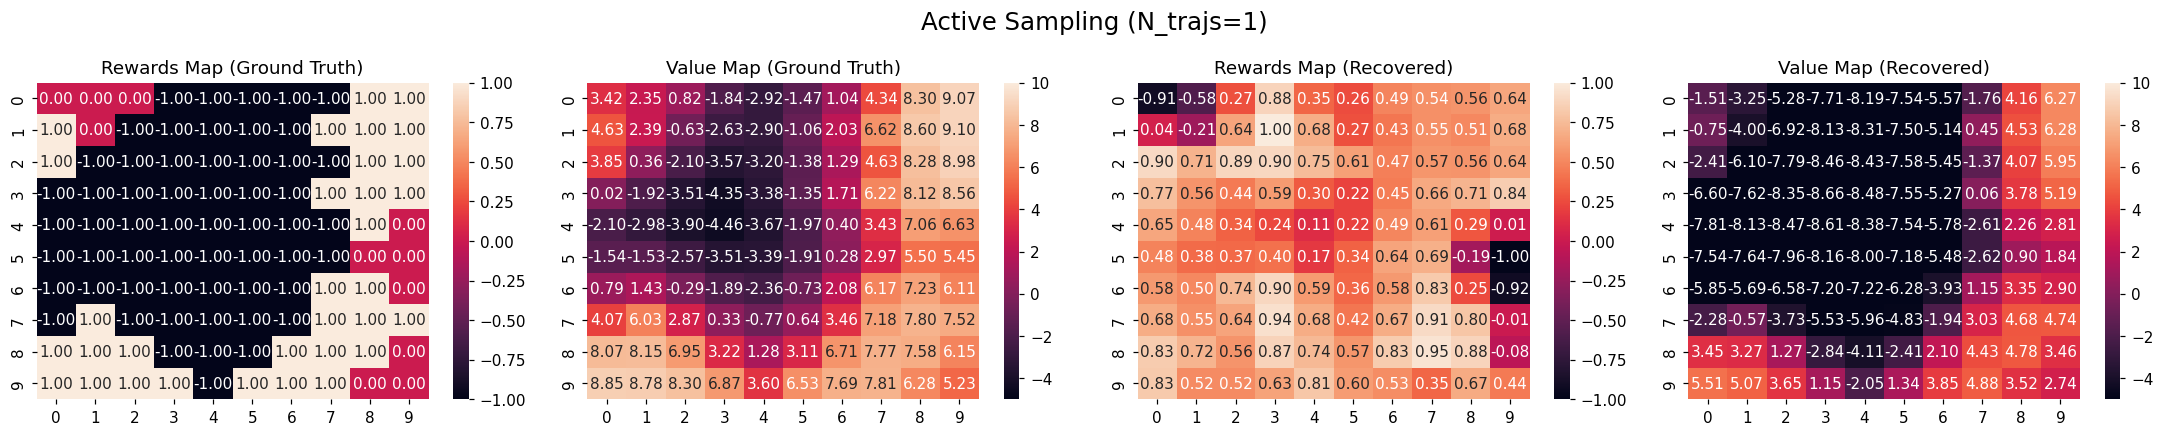

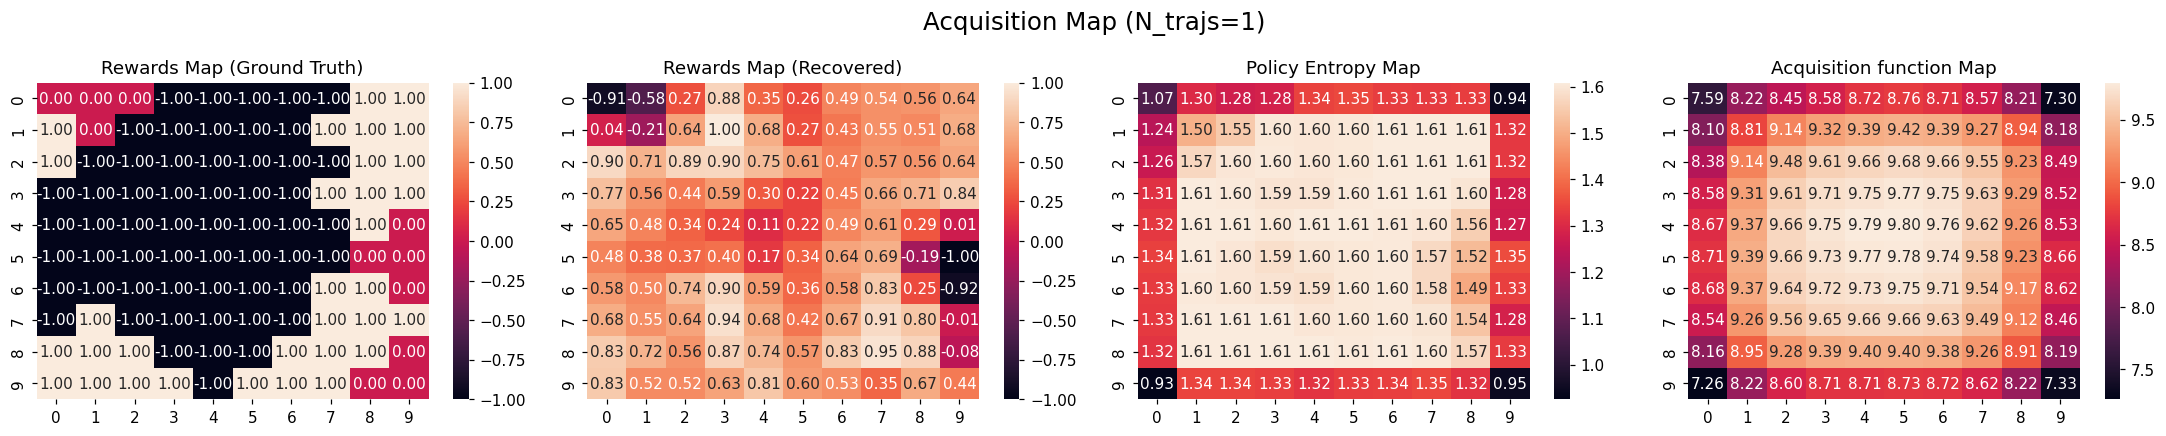

In [11]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

## Random

In [85]:
DEEP_MAXENT_RANDOM_ARGS = """
--exp_name deepmaxent_random
--type object
--n_objects 7
--n_colours 4
--height 6
--width 6
--gamma 0.8
--act_random 0.3
--n_trajs 10
--l_traj 6
--learning_rate 0.001
--n_iters 50
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 2.0
--weight_decay 1.0
--hiddens 16 16
--device cuda
--seed 0
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_RANDOM_ARGS)
print(args.exp_name)
history_deepmaxent_random = run_deepmaxent_irl(args, init_start_pos=init_start_pos)

deepmaxent_random
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
[INFO - n_trajs:1] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:1--
[[ 0.4805  0.1001 -0.2092 -0.3895 -0.4329 -0.2077]
 [ 0.2265 -0.1351 -0.5152 -0.7362 -1.     -0.5341]
 [ 0.2204 -0.0952 -0.6887 -0.7428 -0.7547 -0.539 ]
 [ 0.2788  0.0657 -0.3254 -0.3931 -0.3173 -0.1154]
 [ 0.6383  0.3067  0.0213  0.0904  0.1368  0.3295]
 [ 1.      0.7553  0.6426  0.5983  0.5567  0.7669]]
[INFO - n_trajs:1] Policy evaluation
-- evd = 0.000000 ---
[INFO - n_trajs:1] Generating a new demonstrations from Random Points
Visitation Frequency
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 2]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 2 5]]
[INFO - n_trajs:2] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:2--
[[ 0.6715  0.3637  0.1906  0.2374  0.5632  1.    ]
 [ 0.2794 -0.0439 -0.3614 -0.1572  0.189   0.7986]
 [-0.16   -0.2273 -1.     -0.3631  0.2475  0.8059]
 [-0.741  -0.287  -0.4869 -0.128   0.3569  0.6741]
 [-0.2445 -0.3053 -0.695  -0.0596  0.188   0.5599]
 [ 0.2457  0.0061 -0.0354  0.1569 -0.0655  0.5473]]
[INFO - n_trajs:2] Policy evaluation
-- evd = 0.000000 ---
[INFO - n_trajs:2] Generating a new demonstrations from Random Points
Visitation Frequency
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 2]
 [0 2 1 1 0 1]
 [1 1 0 0 0 1]
 [0 0 0 1 2 5]]
[INFO - n_trajs:3] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:3--
[[-0.0146 -0.1718 -0.1361 -0.0919 -0.1186  0.2177]
 [-0.6767 -0.566  -0.509  -0.5852 -1.     -0.4364]
 [-0.3382 -0.4122 -0.614  -0.7602 -0.9222 -0.9039]
 [-0.0112 -0.1264 -0.3507 -0.5608 -0.6458 -0.5713]
 [ 0.4961  0.1671 -0.1778 -0.1915 -0.3706 -0.2158]
 [ 1.      0.7101  0.5417  0.3259 -0.0942  0.2373]]
[INFO - n_trajs:3] Policy evaluation
-- evd = 0.000000 ---
[INFO - n_trajs:3] Generating a new demonstrations from Random Points
Visitation Frequency
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 3 2 2]
 [0 2 1 1 0 1]
 [1 1 0 0 0 1]
 [0 0 0 1 2 5]]
[INFO - n_trajs:4] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:4--
[[ 0.3119 -0.0324 -0.2023 -0.2709 -0.2765  0.0701]
 [-0.1597 -0.4108 -0.6306 -0.7445 -1.     -0.453 ]
 [-0.1761 -0.387  -0.8498 -0.8549 -0.8619 -0.6638]
 [-0.1321 -0.1534 -0.3939 -0.5255 -0.5201 -0.4139]
 [ 0.4217  0.1256 -0.3055 -0.2322 -0.3428 -0.1684]
 [ 1.      0.6243  0.3758  0.2047 -0.1744  0.1615]]
[INFO - n_trajs:4] Policy evaluation
-- evd = 0.000000 ---
[INFO - n_trajs:4] Generating a new demonstrations from Random Points
Visitation Frequency
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 3 2 2]
 [0 2 1 1 0 1]
 [1 2 1 1 1 2]
 [0 1 0 1 2 5]]
[INFO - n_trajs:5] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:5--
[[ 0.0988 -0.1364 -0.1118  0.119   0.3276  0.7697]
 [-0.4628 -0.5981 -0.6225 -0.3743 -0.1838  0.4068]
 [-0.7481 -0.6896 -1.     -0.5548 -0.2014  0.2316]
 [-0.9971 -0.4877 -0.3341 -0.1995  0.0851  0.4481]
 [-0.3545 -0.1265  0.0577  0.1956  0.3388  0.6772]
 [ 0.3371  0.41    0.6256  0.6723  0.6014  1.    ]]
[INFO - n_trajs:5] Policy evaluation
-- evd = 0.000000 ---
[INFO - n_trajs:5] Generating a new demonstrations from Random Points
Visitation Frequency
[[0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 2 3 2 2]
 [1 3 2 1 0 1]
 [1 2 1 1 1 2]
 [0 1 0 1 2 5]]
[INFO - n_trajs:6] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:6--
[[ 0.5218  0.1688  0.0918  0.2286  0.4932  1.    ]
 [-0.2376 -0.4087 -0.5339 -0.3705 -0.2738  0.3406]
 [-0.3115 -0.4327 -1.     -0.7315 -0.4536 -0.1513]
 [-0.3755 -0.2636 -0.5637 -0.5172 -0.2727 -0.0109]
 [ 0.269  -0.0555 -0.5766 -0.2115 -0.2178  0.1335]
 [ 0.9188  0.541   0.3735  0.3087 -0.1866  0.4501]]
[INFO - n_trajs:6] Policy evaluation
-- evd = 0.000000 ---
[INFO - n_trajs:6] Generating a new demonstrations from Random Points
Visitation Frequency
[[0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 2 3 2 2]
 [1 3 2 1 0 2]
 [1 2 1 1 1 7]
 [0 1 0 1 2 5]]
[INFO - n_trajs:7] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:7--
[[ 0.4836  0.2039  0.1033  0.1394  0.3338  0.9536]
 [-0.1491 -0.3121 -0.5359 -0.5993 -0.8451  0.3879]
 [-0.1519 -0.278  -1.     -0.7883 -0.4245  0.2726]
 [-0.1411 -0.0535 -0.3461 -0.3087 -0.0132  0.3024]
 [ 0.4634  0.1499 -0.4015 -0.0105 -0.0086  0.3448]
 [ 1.      0.662   0.4834  0.4289 -0.0376  0.5476]]
[INFO - n_trajs:7] Policy evaluation
-- evd = 0.000000 ---
[INFO - n_trajs:7] Generating a new demonstrations from Random Points
Visitation Frequency
[[0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 2 3 2 2]
 [1 3 2 1 2 6]
 [1 2 1 1 1 7]
 [0 1 0 1 2 5]]
[INFO - n_trajs:8] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:8--
[[ 0.654   0.2901  0.1095  0.0826  0.1707  0.59  ]
 [ 0.0776 -0.2156 -0.5066 -0.5542 -0.611   0.0795]
 [-0.137  -0.2952 -1.     -0.7394 -0.5064 -0.1468]
 [-0.3407 -0.1081 -0.3487 -0.3345 -0.1186  0.2   ]
 [ 0.3406  0.2    -0.0115  0.153   0.2279  0.5339]
 [ 1.      0.7712  0.7278  0.6984  0.5009  0.9115]]
[INFO - n_trajs:8] Policy evaluation
-- evd = 0.000000 ---
[INFO - n_trajs:8] Generating a new demonstrations from Random Points
Visitation Frequency
[[0 0 3 2 1 0]
 [0 1 0 0 0 0]
 [0 1 2 3 2 2]
 [1 3 2 1 2 6]
 [1 2 1 1 1 7]
 [0 1 0 1 2 5]]
[INFO - n_trajs:9] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:9--
[[ 0.5503  0.3573  0.2858  0.2242  0.0097 -0.0329]
 [ 0.0915  0.0019 -0.0894 -0.209  -0.4967 -0.4918]
 [ 0.0734 -0.03   -0.3952 -0.4053 -0.6971 -1.    ]
 [ 0.0311  0.1806  0.0937 -0.144  -0.3362 -0.2794]
 [ 0.5523  0.5316  0.5728  0.3646  0.2795  0.3676]
 [ 0.9553  0.9511  1.      0.873   0.82    0.9159]]
[INFO - n_trajs:9] Policy evaluation
-- evd = 0.000000 ---
[INFO - n_trajs:9] Generating a new demonstrations from Random Points
Visitation Frequency
[[0 0 3 2 1 0]
 [0 1 0 0 0 0]
 [0 1 2 3 2 2]
 [1 3 2 2 2 6]
 [1 3 2 3 2 7]
 [0 1 0 1 2 5]]
[INFO - n_trajs:10] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:10--
[[-0.1852 -0.3307 -0.3218 -0.302  -0.5077 -0.3941]
 [-0.5833 -0.592  -0.5774 -0.6609 -1.     -0.6942]
 [-0.4967 -0.5183 -0.6284 -0.6206 -0.7941 -0.7323]
 [-0.3663 -0.1811 -0.0605 -0.2224 -0.3217 -0.1739]
 [ 0.1977  0.3047  0.5776  0.3283  0.299   0.4193]
 [ 0.7313  0.829   1.      0.8843  0.914   0.9914]]
[INFO - n_trajs:10] Policy evaluation
-- evd = 0.000000 ---


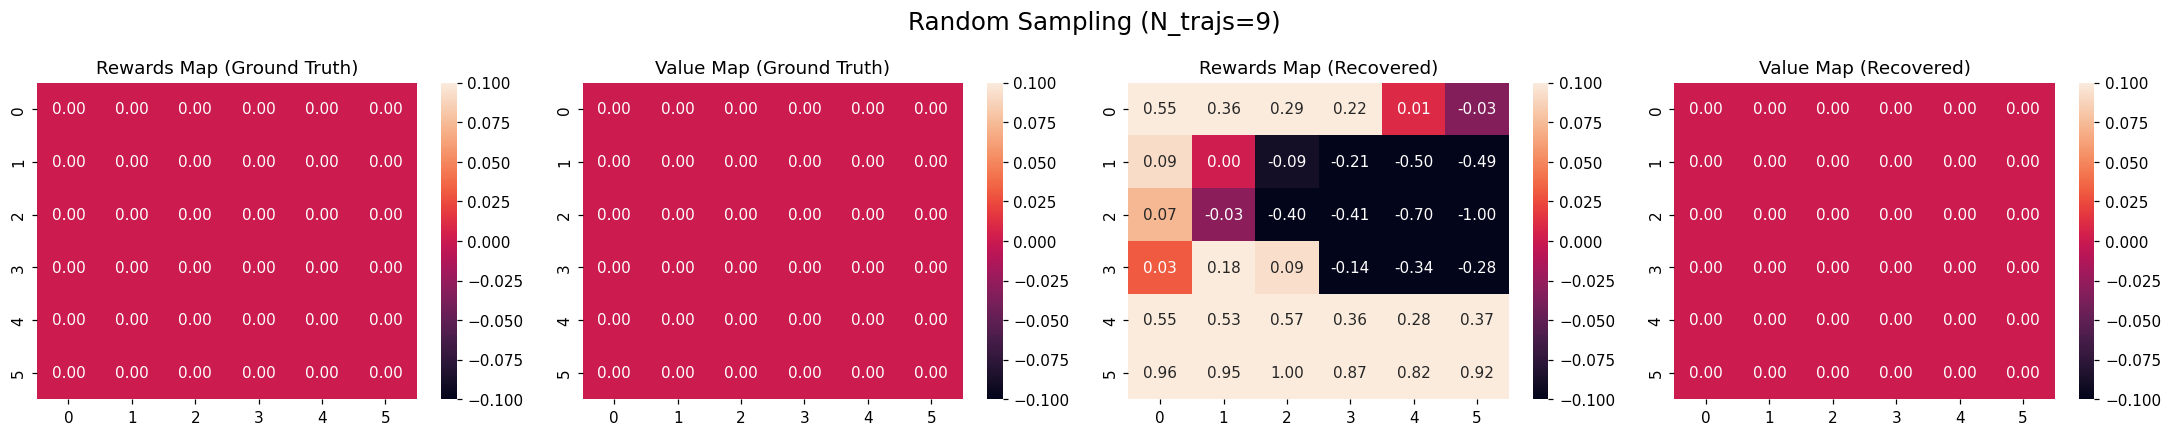

In [87]:
visualizer = Visualizer(history_deepmaxent_random, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)